In [15]:
import numpy as np
import random as rnd
import scipy.spatial.distance as distance
import math
import scipy.stats as stats
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plot
import scipy
import random
import traceback

In [2]:
#Calculate mahalanobis distance
def myMahalanobis(x, mu, alpha):
    return np.matmul((x - mu).transpose(),np.matmul(alpha, x - mu))

In [3]:
#def merge(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, sigmaInv, x)

In [3]:
# create a new component (representative of a multivariate gaussian distribution)
# TODO stop this form changing X
def create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, x):
    accumulators[K] = 1
    ages[K] = 1
    alphas[K] = sigmaInv * np.identity(len(alphas[0]))
    comProbs[K] = 1 / sum(accumulators.values())
    covDets[K] = np.linalg.det(alphas[K]) ** -1
    mus[K] = 0 + x
    #print(mus[K])
    x += 1
    ##print(mus[K])
    #print()
    x -= 1
    K += 1
    return K


In [45]:
# update a component j using the posterior probabilities of data point x
#Algorithm 2 update
# TODO stop this from changing X
def update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, sigmaInv, x):
    #equation 22
    dist = myMahalanobis(x, mus[j], alphas[j]) ** 2
    
    #equation 2
    pxj = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[j])) * math.exp(-0.5 * dist)#
   
    try:
        pxj = math.log(pxj)
        pxj = math.exp(pxj)
    except ValueError as err:
        print(str(err) + traceback.format_exc() + "dist = {}, pxj = {}, covDets[j] = {}".format(dist, pxj, covDets[j]))
    if printing:
        print(pxj)
    
    #equation 3
    pjx = pxj * comProbs[j]#
    totProbs = 0
    for i in range(K):
        pxi =  1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[i])) * math.exp(-0.5 * dist)#
        totProbs += pxi * comProbs[i]#
        
    if totProbs == 0:
        print(comProbs)
        print()
    try:
        pjx /= totProbs# 
    
    except ZeroDivisionError as err:
        print(str(err) + traceback.format_exc() + "pjx = {}, totProbs = {}".format(pjx, totProbs))
        
        
    if printing:
        print(pjx)
    
    #equation 4,5
    ages[j] += 1
    accumulators[j] += pjx
    
    #equations 6,7
    ej = x - mus[j]
    weight = pjx / accumulators[j]
    
    #equation 8,9
    deltaMu = weight * ej
    mus[j] += deltaMu

    oldAlpha = alphas[j]

    #equation 10
    ejStar = x - mus[j]
    
    #equation 20
    newAlpha = oldAlpha / (1 - weight) - (weight / (1 - weight) ** 2) * np.matmul(np.matmul(oldAlpha, ejStar), np.matmul(ejStar.transpose(), oldAlpha)) \
            / (1 + (weight / (1 - weight)) * np.matmul(np.matmul(ejStar.transpose(), oldAlpha),ejStar))
    
    #equation 21
    alphas[j] = newAlpha +  (np.matmul(np.matmul(newAlpha, mus[j]), np.matmul(mus[j].transpose(), newAlpha))) \
            / (1 - np.matmul(np.matmul(mus[j].transpose(), newAlpha), mus[j]))
    
    #equation 12
    comProbs[j] = accumulators[j] / sum(accumulators.values())
    
    #equations 25, 26
    newCovDet = (1 - weight) ** D * covDets[j] * (1 + weight/(1 - weight) * np.matmul(ejStar.transpose(), np.matmul(oldAlpha, ejStar)))
    covDets[j] = newCovDet * (1 - np.matmul(deltaMu.transpose(), np.matmul(newAlpha, deltaMu)))

    return mus
    

In [5]:
# remove a component after it was merged with another component in the model
def remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK):
    correspondingData[-1].append(correspondingData[j])
    
    for i in range(j,len(ages) - 1):
        accumulators[i] = accumulators.pop(i + 1)
        ages[i] = ages.pop(i + 1)
        alphas[i] = alphas.pop(i + 1)
        comProbs[i] = comProbs.pop(i + 1)
        correspondingData[i] = correspondingData.pop(i + 1)
        covDets[i] = covDets.pop(i + 1)
        mus[i] = mus.pop(i + 1)
    
    comProbs = removeHelper(comProbs, accumulators)
    return comProbs

In [6]:
#TODO find workaround for type to use logsumexp
def removeHelper(comProbs, accumulators):
    val = len(accumulators)
    for i in range(val):
        summed = 0
        for j in range(val):
            summed += accumulators[j]
        comProbs[i] = accumulators[i] / summed
    return comProbs

In [7]:
# generate data from 5 normal gaussian distributions
#set plotting to True to see the scatter plots of generated data
#TODO plot sigmas of starting gaussians
def generateData(plotting = False):
    #TODO create dict to map key to data correspondence to mu/sigma, 4 keys, mu, sigma, discover mu, discover sigma 
    D = 4; K = 0; Beta = 0.05; delta = 0.01
    vmin = 5; spmin = 3
    mus = np.ndarray([D + 1,2]); sigmas = np.ndarray([D+1,2,2])
    mus = np.array([[1, 1], [10, 10], [10,1], [1,10], [5,5]])
    
    for i in range(D + 1):
        sigmas[i] = [[1, 0], [0, 1]]

    startingMus = mus
    numvectors = 250; lenvectors = 2
    X = np.ndarray((numvectors, lenvectors))



    for i in range(numvectors):
        index = i % (D + 1)
        
        for j in range(lenvectors):
            X[i] = np.random.multivariate_normal(mus[index], sigmas[index])
    if plotting:       
        Xs = [[],[],[],[],[]]
        Ys = [[],[],[],[],[]]
        colors = ['r','b','g','y','m']

        for i in range(len(X)):
            index = i % 5
            Xs[index].append(X[i,0])
            Ys[index].append(X[i,1])

        for i in range(5):
            plot.scatter(Xs[i], Ys[i], c =colors[i])
            
    return [X, startingMus, sigmas]
# return the generated data, and the mus and sigmas of the gaussians used to generate the data

In [37]:
# generate data from 5 normal gaussian distributions
#set plotting to True to see the scatter plots of generated data
#TODO plot sigmas of starting gaussians
def generateData3(plotting = False):
    #TODO create dict to map key to data correspondence to mu/sigma, 4 keys, mu, sigma, discover mu, discover sigma 
    D = 4; K = 0; Beta = 0.05; delta = 0.01
    vmin = 5; spmin = 3
    mus = np.ndarray([D + 1,2]); sigmas = np.ndarray([D+1,2,2])
    mus = np.array([[1, 1], [10, 10], [10,1], [1,10], [5,5]])
    
    for i in range(D + 1):
        sigmas[i] = [[1, 0], [0, 1]]

    startingMus = mus
    numvectors = 250; lenvectors = 2
    X = np.ndarray((numvectors, lenvectors))
    startingCorrespondences = []


    for i in range(numvectors):
        index = random.randint(0,4)
        startingCorrespondences.append(index)
        X[i] = np.random.multivariate_normal(mus[index], sigmas[index])
        
    if plotting:       
        Xs = [[],[],[],[],[]]
        Ys = [[],[],[],[],[]]
        colors = ['r','b','g','y','m']

        for i in range(len(X)):
            index = startingCorrespondences[i]
            Xs[index].append(X[i,0])
            Ys[index].append(X[i,1])

        for i in range(5):
            plot.scatter(Xs[i], Ys[i], c =colors[i])
            
    return [X, startingMus, sigmas, startingCorrespondences]
# return the generated data, and the mus and sigmas of the gaussians used to generate the data

In [49]:
#TODO use Z score instead of mahalanobis distance to fall into 
# simulate the IGMM process for input data stream X
# set printing parameter to true to see final correspondences from the IGMM generated mus to the mus used in data generation
def simulate(X, sigmas, startingMus, delta = 1, dimension = 2, D = 4, vmin = 5, spmin = 3, printing = False):
    sigma = np.std(X[:10]) #sigma should be representative of only a part of the data stream
    sigmaInv = delta * (sigma) ** -1
    alpha = sigmaInv * np.identity(dimension)
    covarDet = np.linalg.det(alpha) ** -1

    alphas = {}
    mus = {}
    covDets = {}
    comProbs = {}
    ages = {}
    accumulators ={}
    correspondingData = {}

    alphas[0] = alpha
    covDets[0] = covarDet
    mus[0] = X[0]
    comProbs[0] = 1
    ages[0] = 1
    accumulators[0] = 1
    K = 1
    remainingK = D
    correspondingData[0] = [0]
    correspondingData[-1] = []
    correspondingData[-2] = []
    
    for i in range(len(X)):
        if i == 0:
            continue
        updated = False

        for j in range(K):
            if j >= K:
                break
#             if (ages[j] > vmin) and (accumulators[j] < spmin):
#                 comProbs = remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j, mus, remainingK)
#                 remainingK += 1
#                 K -= 1
                
#                 if printing:
#                     print('call remove')
#                     print()

        for j in range(K):
            if i == j:
                continue

            
            dist = myMahalanobis(X[i], mus[j], alphas[j]) ** 2
            if printing:
                print('(' + str(i) + ', ' + str(j) + ')')
                print(dist)

            
            if dist < 10:
                if printing:
                    print('call update')
                    print()
                correspondingData[j].append(i)
                mus = update(accumulators, ages, alphas, comProbs, covDets, D, j, K, mus, printing, sigmaInv, X[i])
                #print('mu3 = {}'.format(mus[j]))
                #print()
                updated = True

            ##!!!!!! This may be problematic, only comparing means
        if K > 1:
            for i1 in range(K):
                for j1 in range(i):
                    if i1 == j1:
                        continue
                    if i1 < K and j1 < K:
                        mat = (np.linalg.inv(alphas[i1]) + np.linalg.inv(alphas[j1])) / 2
                        alp = np.linalg.inv(mat)
                        comDist = myMahalanobis(mus[i1], mus[j1], alp) ** 2
                        if comDist < 0.1:
                            
                            #print('merged')
                            #print('i = {}, j = {}, meani = {}, meanj = {}'.format(i1, j1, mus[i1], mus[j1]))
                            #print()
                            for k in correspondingData[i1]:
                                #print('correspondingData = {}'.format(correspondingData[i1]))
                                #print('correspondingData = {}'.format(correspondingData[j1]))
                                if k not in correspondingData[j1]:
                                    dist = myMahalanobis(X[i], mus[j], alphas[j]) ** 2
                                    if dist < 10:
                                        update(accumulators, ages, alphas, comProbs, covDets, D, i1, K, mus, printing, sigmaInv, X[k])
                                        correspondingData[i1].append(k)
                                    else:
                                        correspondingData[-2].append(k)
                                #print('correspondingData = {}\n'.format(correspondingData[i1]))
                            remove(accumulators, ages, alphas, comProbs, correspondingData, covDets, j1, mus, remainingK)
                            remainingK += 1
                            K -= 1
         ## end !!!!!!
    
        
        if not updated and remainingK == 0:
            correspondingData[-1].append(i)
        
        if not updated and not remainingK == 0:
            if printing:
                print('call create')
                print()
            correspondingData[K] = [i]
            K = create(accumulators, ages, alphas, comProbs, covDets, K, mus, sigmaInv, X[i])
            remainingK -= 1
            

    if printing:
        print(K)
    norms = np.ndarray([D + 1, K])
    difference = 0
    correspondences = np.ndarray(D + 1)
    for i in range(D + 1): #D + 1 = len(startingMus)
        for j in range(K):
            norms[i, j] = np.linalg.norm(startingMus[i] - mus[j])
        index = np.argmin(norms[i])
        difference += norms[i,index]
        correspondences[i] = index
        
        if printing:
            print("mu = {}, sigma = {}".format(mus[index], np.linalg.inv(alphas[index])))
            print("starting mu = {}, starting Sigma = {}".format(startingMus[i], sigmas[i]))
            print("corresponding data = {}\n".format(correspondingData[index]))


        #TODO handle case when
    if printing:
        print(str(difference) + '\n')
        print(correspondingData)
            
    
    return [alphas, correspondingData, difference, mus, K, comProbs, covDets]

In [9]:
# Takes in an array of outliers and calculates their posterior probabilities for each of the gaussians produced by the IGMM

def getSoftProbs(alphas, comProbs, covDets, K, mus, outliers, Xini):
    X = np.copy(Xini)
    D = K - 1
    softProbs = np.ndarray([len(outliers),K])
    probs = np.ndarray([K])
    for i in range(len(outliers)):
        for j in range(K):
            dist = myMahalanobis(X[i], mus[j], alphas[j]) ** 2
            probs[j] = 1 / ((2 * math.pi) ** (D / 2) * math.sqrt(covDets[j])) * math.exp(-0.5 * dist) * comProbs[j]

        probsum = sum(probs)
        
        for j in range(K):
            softProbs[i,j] = probs[j] / probsum
    return softProbs
        

In [10]:
# simulate the igmm and calculate the distance from the resulting means to the original means, then roll the input matrix
# and repeat until we minimize the distance between the resulting means and original means
# number of trials determines how many times we roll the matrix and test
# TODO verify this output matches expected differences and correctly finds optimal starting data point
# TODO fine tune this to ensure proper input is used during each trial and is not altered during trials
def sieve(Data, K = 5, D = 4, printing = False, trials = 50): 
    
    savedData = np.copy(Data)
    differences = np.ndarray(trials)
    X = Data[0]; sigmas = Data[2]; startingMus = Data[1]
    
    for t in range(trials):
        [alphas, correspondingData, difference, mus, K, comProbs, covDets] = simulate(X = Data[0], sigmas = Data[2], startingMus = Data[1], printing = False)

    
        norms = np.ndarray([D + 1, K])
        difference = 0
        correspondences = np.ndarray(D + 1)

        for i in range(D + 1): #D + 1 = len(startingMus)
            for j in range(K):
                norms[i, j] = np.linalg.norm(startingMus[i] - mus[j])
            index = np.argmin(norms[i])
            difference += norms[i,index]
            correspondences[i] = index
            if printing:    
                print("mu = {}, sigma = {}".format(mus[index], np.linalg.inv(alphas[index])))
                print("starting mu = {}, starting Sigma = {}".format(startingMus[i], sigmas[i]))
                print("corresponding data = {}\n".format(correspondingData[index]))


        if printing:
            print(str(difference) + '\n')
            print(correspondingData)

        if t == 0:
            mindifference = difference
            besti = 0

        elif mindifference > difference:
            mindifference = difference
            besti = t

        differences[t] = difference

        Data = np.copy(savedData)
        X = np.roll(Data[0],1); sigmas = Data[2]; startingMus = Data[1]


    return [mindifference, besti, differences]

mu = [1.2172684  0.73814612], sigma = [[ 0.6866011  -0.76312275]
 [-0.76312275  0.6866011 ]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 13, 15, 16, 25, 40, 44, 57, 88, 124, 136, 137, 159, 160, 173, 178, 195, 197, 217]

mu = [9.43120692 9.39811544], sigma = [[ 0.486911   -0.96878112]
 [-0.96878112  0.486911  ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 32, 33, 36, 39, 42, 49, 58, 59, 61, 64, 65, 70, 72, 75, 78, 79, 83, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 227, 234, 246, 247]

mu = [4.67066975 4.66024075], sigma = [[ 0.275742   -0.71207396]
 [-0.71207396  0.275742  ]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [3, 8, 13, 31, 37, 43, 48, 50, 51, 54, 55, 56, 60, 71, 73, 76, 81, 84, 85, 92, 95, 103, 112, 126, 128, 130, 132, 141, 142, 145, 150, 151, 152, 155, 162, 174, 175, 192, 193, 204, 205, 215,

mu = [4.26014836 4.81147555], sigma = [[ 1.474357   -0.58767822]
 [-0.58767822  1.474357  ]]
starting mu = [5 5], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [3, 8, 13, 31, 37, 43, 48, 50, 51, 54, 55, 56, 60, 71, 73, 76, 81, 84, 85, 92, 95, 103, 112, 126, 128, 130, 132, 141, 142, 145, 150, 151, 152, 155, 162, 174, 175, 188, 192, 193, 204, 205, 212, 214, 215, 218, 222, 229, 242]

11.92223769784109

{0: [0, 8, 10, 56, 89, 115, 233], -1: [7, 11, 14, 15, 16, 17, 18, 20, 25, 27, 28, 34, 35, 38, 40, 44, 45, 53, 57, 62, 67, 68, 86, 88, 90, 91, 94, 96, 98, 100, 105, 107, 109, 110, 111, 113, 114, 117, 118, 121, 122, 124, 127, 131, 133, 134, 136, 137, 138, 140, 144, 147, 149, 153, 156, 157, 159, 160, 161, 163, 164, 167, 168, 171, 172, 173, 177, 178, 179, 185, 186, 189, 191, 194, 195, 197, 198, 199, 202, 207, 208, 211, 216, 217, 219, 220, 221, 224, 225, 232, 235, 237, 238, 239, 240, 241, 243, 244, 245, 248, 249], -2: [], 1: [1, 4, 5, 9, 10, 12, 21, 26, 30, 42, 46, 176, 187, 190, 201,

mu = [4.73109313 4.7197824 ], sigma = [[ 0.15061322 -0.07625327]
 [-0.07625327  0.15061322]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28532246 9.52425938], sigma = [[ 1.22704328 -0.57227941]
 [-0.57227941  1.22704328]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37080672 1.16244897], sigma = [[ 1.11886394 -0.92988169]
 [-0.92988169  1.11886394]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05943275 9.47595675], sigma = [[ 0.77288157 -0.9223971

mu = [4.7314605  4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.22742559 -0.57224444]
 [-0.57224444  1.22742559]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593322], sigma = [[ 0.77296217 -0.9224918

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.92249187]
 [-0.92249187  0.77296217]]
starting mu = [ 1 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [6, 9, 10, 12, 19, 21, 22, 26, 30, 47, 52, 63, 66, 69, 74, 77, 80, 82, 87, 97, 99, 104, 120, 158, 165, 170, 180, 181, 183, 196, 200, 223, 226, 

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.9224918

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.9224918

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.92249187]
 [-0.92249187  0.77296217]]
starting mu = [ 1 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [6, 9, 10, 12, 19, 21, 22, 26, 30, 47, 52, 63, 66, 69, 74, 77, 80, 82, 87, 97, 99, 104, 120, 158, 165, 170, 180, 181, 183, 196, 200, 223, 226, 

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.9224918

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.9224918

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [5 5], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

7.692758313579653

{0: [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175], -1: [15, 16, 17, 18, 25, 27, 40, 42, 43, 44, 45, 48, 50, 51, 53, 56, 57, 60, 61, 67, 68, 71, 78, 83, 84, 86, 88, 89, 94, 95, 98, 100, 102, 103, 105, 109, 110, 111, 112, 113, 114, 115, 117, 118, 121, 122, 124, 128, 131, 133, 134, 136, 137, 138, 141, 142, 147, 150, 152, 157, 159, 160, 161, 168, 169, 171, 173, 176, 178, 179, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 201, 202, 203, 204, 205, 207, 208, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 224, 225, 229, 230, 232, 233, 235, 238, 239, 240, 241, 242, 243, 245, 248, 249], -2: [], 1: [1, 4, 5, 9, 10, 12, 21, 26, 29, 46, 187], 2: [2, 23, 24, 29, 33, 36,

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.9224918

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.9224918

mu = [4.73146051 4.72014375], sigma = [[ 0.15066318 -0.076181  ]
 [-0.076181    0.15066318]]
starting mu = [1 1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [0, 3, 8, 31, 37, 54, 73, 76, 81, 85, 92, 126, 130, 132, 151, 155, 162, 174, 175]

mu = [9.28535605 9.5242934 ], sigma = [[ 1.2274256  -0.57224444]
 [-0.57224444  1.2274256 ]]
starting mu = [10 10], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [2, 23, 24, 29, 33, 36, 39, 49, 55, 58, 59, 64, 65, 70, 72, 75, 77, 79, 90, 93, 101, 106, 108, 116, 119, 123, 125, 129, 135, 139, 143, 146, 148, 154, 166, 182, 184, 206, 209, 210, 221, 227, 234, 246, 247]

mu = [9.37074959 1.16250488], sigma = [[ 1.11892694 -0.92993086]
 [-0.92993086  1.11892694]]
starting mu = [10  1], starting Sigma = [[1. 0.]
 [0. 1.]]
corresponding data = [7, 11, 13, 14, 20, 28, 32, 34, 35, 38, 41, 62, 91, 96, 107, 127, 140, 144, 145, 149, 153, 156, 163, 164, 167, 172, 177, 237, 244]

mu = [1.05942916 9.47593321], sigma = [[ 0.77296217 -0.9224918

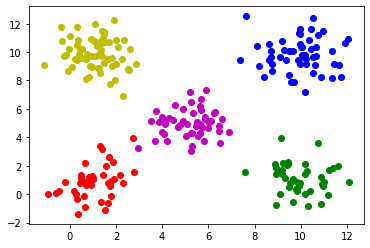

In [53]:
Data = generateData3(True) #generate some data without plotting it
Xini = np.copy(Data[0]) #save a copy of the input datastream (avoid losing it during update)
sievedData = sieve(Data, printing = True) # sieve the data to determine the ideal starting input
#print the results
#print(sievedData[0])
#print(sievedData[1])
#print(min(sievedData[2]))
#print(sievedData[2])
#print(0 in sievedData[2])

#[alphas, correspondingData, difference, mus, K, comProbs, covDets] = simulate(X = Data[0], sigmas = Data[2], startingMus = Data[1], printing = False)
#alphas = simulatedData[0]
#correspondingData = simulatedData[1]
#mus = simulatedData[3]

#softProbs = getSoftProbs(alphas, comProbs, covDets, K, mus, correspondingData[-1], Xini)
#print(len(softProbs))
#print(softProbs)



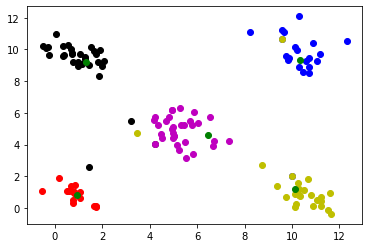

In [21]:
#Some code for plotting that needs to be turned into a new funtion
#TODO finetune merge
colors = ['r', 'b', 'y', 'k', 'm']
for i in range(len(mus)):
    plot.figure(1)
    A = correspondingData[i]
    Xs_to_plot = Xini[A,0]
    Ys_to_plot = Xini[A,1]
    plot.scatter(Xs_to_plot, Ys_to_plot, c = colors[i])
    plot.scatter((mus[i][0]), (mus[i][1]), c = 'g')

